In [2]:
from __future__ import print_function

# to be able to see plots
%matplotlib inline  
import matplotlib.pyplot as plt

import numpy as np
import _pickle as cPickle

import sys
sys.path.append("../tools")

from tools import collage

# just to use a fraction of GPU memory 
# This is not needed on dedicated machines.
# Allows you to share the GPU.
gpu_memory_usage=0.33
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_memory_usage
set_session(tf.Session(config=config))



Using TensorFlow backend.


# Read CIFAR10 dataset

Trn data shape: (100000, 32, 32, 3)
Tst data shape: (20000, 32, 32, 3)
Trn labels shape:  (100000,)
Tst labels shape:  (20000,)
(128, 128, 3)


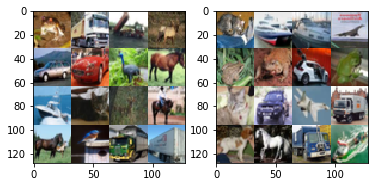

In [3]:
from tools import readCIFAR, mapLabelsOneHot

# First run ../data/downloadCIFAR.sh 
trnData, tstData, trnLabels, tstLabels = readCIFAR('../data/cifar-10-batches-py')

plt.subplot(1, 2, 1)
img = collage(trnData[:16])
print(img.shape)
plt.imshow(img)
plt.subplot(1, 2, 2)
img = collage(tstData[:16])
plt.imshow(img)
plt.show()

trnLabels = mapLabelsOneHot(trnLabels)
tstLabels = mapLabelsOneHot(tstLabels)


# Normalize data

In [4]:
trnData = trnData.astype(np.float32) / 255.0 - 0.5
tstData = tstData.astype(np.float32) / 255.0 - 0.5

# Define net

In [5]:
from keras.layers import Input, Reshape, Dense, Dropout, Flatten
from keras.layers import Activation
from keras.models import Model
from keras import regularizers

w_decay = 0.0001
w_reg = regularizers.l2(w_decay)

def get_simple_FC_network(input_data, layer_cout, layer_dim):

    net = Flatten()(input_data)
    for i in range(layer_cout):
        net = Dense(layer_dim, activation='relu')(net)
    
    net = Dense(10, name='out', activation='softmax')(net)

    return net


In [6]:
from keras import optimizers
from keras.models import Model
from keras import losses
from keras import metrics

input_data = Input(shape=(32, 32, 3), name='data')
net = get_simple_FC_network(input_data, 5, 256)
model = Model(inputs=[input_data], outputs=[net])

# Build stacked GAN model
print('Model')
model.summary()

model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=0.001), metrics=[metrics.categorical_accuracy])



Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               786688    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
____

In [ ]:
from keras import backend
model.fit(
    x=trnData, y=trnLabels,
    batch_size=64, epochs=10, verbose=1, 
    validation_data=[tstData, tstLabels], shuffle=True)

Train on 100000 samples, validate on 20000 samples
Epoch 1/10
100000/100000 [==============================] - 29s - loss: 1.5813 - categorical_accuracy: 0.4371 - val_loss: 1.4476 - val_categorical_accuracy: 0.4810
Epoch 2/10
100000/100000 [==============================] - 28s - loss: 1.3491 - categorical_accuracy: 0.5214 - val_loss: 1.3473 - val_categorical_accuracy: 0.5243
Epoch 3/10
100000/100000 [==============================] - 27s - loss: 1.2332 - categorical_accuracy: 0.5609 - val_loss: 1.3242 - val_categorical_accuracy: 0.5351
Epoch 4/10
100000/100000 [==============================] - 26s - loss: 1.1463 - categorical_accuracy: 0.5912 - val_loss: 1.3008 - val_categorical_accuracy: 0.5486
Epoch 5/10
100000/100000 [==============================] - 25s - loss: 1.0663 - categorical_accuracy: 0.6193 - val_loss: 1.3043 - val_categorical_accuracy: 0.5487
Epoch 6/10
100000/100000 [==============================] - 26s - loss: 0.9931 - categorical_accuracy: 0.6432 - val_loss: 1.3286 

# Predict and evaluate

In [41]:
classProb = model.predict(x=tstData[0:2])
print('Class probabilities:', classProb, '\n')
loss, acc = model.evaluate(x=tstData, y=tstLabels, batch_size=1024)
print()
print('loss', loss)
print('acc', acc)

Class probabilities: [[  9.80168920e-07   1.24866101e-05   1.37486206e-02   9.51471329e-01
    9.77429328e-04   2.80619413e-02   1.87052353e-06   1.47242844e-03
    1.97114716e-07   4.25267452e-03]
 [  7.14849262e-03   1.58888707e-03   9.96495801e-05   9.94615039e-05
    1.04357741e-05   1.70477415e-05   2.99519947e-04   6.58281861e-05
    9.79999423e-01   1.06712980e-02]] 

18432/20000 [==========================>...] - ETA: 0s
loss 1.79701059799
acc 0.545050000095


# Compute test accuracy by hand

In [47]:
classProb = model.predict(x=tstData)
print(classProb.shape)

correctProb = (classProb * tstLabels).sum(axis=1)
wrongProb = (classProb * (1-tstLabels)).max(axis=1)
print(correctProb.shape, wrongProb.shape)

accuracy = (correctProb > wrongProb).mean()
print('Accuracy: ',  accuracy)

(20000, 10)
(20000,) (20000,)
Accuracy:  0.54505
